In [1]:
import argparse
import math
import os
import pickle
import re
import shutil
from collections import defaultdict
from os import listdir
from os.path import dirname, isfile, join
from pathlib import Path

import apex
import numpy as np
import pandas as pd
import torch
import torch.distributed as dist
import torch.multiprocessing as mp
import torch.nn as nn
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import sys

# setting path
sys.path.append('../../DeepAtles')
import run_search

sys.path.append('../../DeepAtles/src')

# importing

from src.atlespredict import (dbsearch, pepdataset, postprocess, preprocess,
                          specdataset, specollate_model)
from src.atlestrain import dataset, model
from src.atlesutils import simulatespectra as sim
from src.atlesconfig import config
config.PARAM_PATH = '../config.ini'

In [2]:
def create_out_dir(dir_path, exist_ok=True):
    out_path = Path(dir_path)
    if out_path.exists() and out_path.is_dir():
        if not exist_ok:
            shutil.rmtree(out_path)
            out_path.mkdir()
    else:
        out_path.mkdir()

    # Path(join(out_path, 'spectra')).mkdir()
    # Path(join(out_path, 'peptides')).mkdir()


def verify_in_dir(dir_path, ext, ignore_list):
    in_path = Path(dir_path)
    assert in_path.exists() and in_path.is_dir()

    files = [join(dir_path, f) for f in listdir(dir_path) if
             isfile(join(dir_path, f)) and not f.startswith('.')
             and f.split('.')[-1] == ext and f not in ignore_list]
    assert len(files) > 0
    return files


def isfloat(str_float):
    try:
        float(str_float)
        return True
    except ValueError:
        return False


def mod_repl(match):
    lookup = str(round(float(match.group(0)), 2))
    return config.ModCHAR[lookup] if lookup in config.ModCHAR else ""


def mod_filt(pep, mods, count):
    is_valid = True
    current_count = 0
    for aa in pep:
        if aa.islower() and aa != "c":
            if aa not in mods:
                is_valid = False
                break
            else:
                current_count += 1
                if current_count > count:
                    is_valid = False
                    break

    return is_valid


def gray_code(num):
    return num ^ (num >> 1)


def decimal_to_binary_array(num, arr_len):
    bin_arr = [float(i) for i in list('{0:0b}'.format(num))]
    assert len(bin_arr) <= arr_len
    res = [0.] * (arr_len - len(bin_arr)) + bin_arr
    # greater than zero. 0.1 for the floating pointing errors.
    inds = [int(i) for i, _ in enumerate(res) if res[i] > 0.1]
    vals = [1.0] * len(inds)
    return inds, vals


In [44]:
import re


def preprocess_mgfs(mgf_dir, out_dir):

    mgf_files = verify_in_dir(mgf_dir, "mgf", [])
    create_out_dir(out_dir, exist_ok=False)

    print('reading {} files'.format(len(mgf_files)))

    spec_size = config.get_config(section='input', key='spec_size')
    print("spec size: {}".format(spec_size))
    charge = config.get_config(section='input', key='charge')
    max_pep_len = config.get_config(section='ml', key='max_pep_len')
    min_pep_len = config.get_config(section='ml', key='min_pep_len')
    max_spec_len = config.get_config(section='ml', key='max_spec_len')
    test_size = config.get_config(section='ml', key='test_size')
    max_clvs = config.get_config(section='ml', key='max_clvs')

    non_mod_c = 0

    ch = np.zeros(20)
    lens = np.zeros(max_pep_len)
    modified = 0
    unmodified = 0
    unique_pep_set = set()

    clvs_dist = np.zeros(max_clvs + 1)

    pep_spec = []

    summ = np.zeros(spec_size)
    sq_sum = np.zeros(spec_size)
    N = 0

    spec_out = []
    pep_props = []

    tot_count = 0
    max_peaks = max_moz = max_missed_cleavs = 0
    for file_id, mgf_file in enumerate(mgf_files):
        print('Reading: {}'.format(mgf_file))

        f = open(mgf_file, "r")
        lines = f.readlines()
        f.close()

        count = lcount = 0
        mass_ign = 0
        pep_len_ign = 0
        dup_ign = 0

        print('len of file: ' + str(len(lines)))
        limit = 200000
        pep = []
        spec = []
        is_title = is_name = is_mw = is_charge = False
        prev = 0
        i = 0
        while i < len(lines) and limit > 0:
            line = lines[i]
            i += 1

            if line.startswith('TITLE'):
                split_len = len(line.split('.'))
                scan_id = int(line.split('.')[-3]) if split_len >= 3 else int(line.split('=')[-1])
                is_title = True

            if is_title and line.startswith('PEPMASS'):
                count += 1
                mass = float(re.findall(r"PEPMASS=([-+]?[0-9]*\.?[0-9]*)", line)[0])
                is_mw = True
#                 if round(mass)*10 < spec_size:
#                     is_mw = True
#                     # limit = limit - 1
#                 else:
#                     is_name = is_mw = is_charge = False
#                     mass_ign += 1
#                     continue

            if is_title and is_mw and line.startswith('CHARGE'):
                l_charge = int(re.findall(r"CHARGE=([-+]?[0-9]*\.?[0-9]*)", line)[0])
                mass = (mass - config.PROTON) * l_charge
                is_charge = True
                if l_charge > charge or round(mass*10) > spec_size:
                    is_title = is_name = is_mw = is_charge = False
                    continue

            if is_title and is_mw and is_charge and line.startswith("SEQ"):
                line = re.sub(r"[()]", "", line.strip()).split('=')[-1]
                mod_repl_rex = r'([-+]?\d*\.\d+|[-+]?\d+)'
                pep, num_mods = re.subn(mod_repl_rex, mod_repl, line)
                pep_len = sum(map(str.isupper, pep))
                missed_cleavs = (pep.count("K") + pep.count("R")) - (pep.count("KP") + pep.count("RP"))
                if pep[-1] == 'K' or pep[-1] == 'R':
                    missed_cleavs -= 1
                if missed_cleavs > max_clvs:
                    is_title = is_name = is_mw = is_charge = False
                    continue
                clvs_dist[missed_cleavs] += 1
                num_mods -= len(re.findall("c", pep))
#                 max_missed_cleavs = max(missed_cleavs, max_missed_cleavs)

#                 if re.search(r"([a-z]{2,})", pep):
#                     print(pep)
                mods = ["p", "o"]
                count = 3
                # if len(pep) + 2 > seq_len or "O" in pep or "U" in pep or re.search(r"([a-z]{2,})", pep) or 
                # not mod_filt(pep, mods, count):
                if pep_len >= max_pep_len or pep_len < min_pep_len or "O" in pep or "U" in pep or \
                    re.search(r"([^oA-Z])", pep): # or re.search(r"([a-z]{2,})", pep):
                    pep_len_ign += 1
                    is_title = is_name = is_mw = is_charge = False
                    continue

                ch[l_charge] += 1
                lens[pep_len - min_pep_len] += 1
                if num_mods > 0:
                    modified += 1
                    # is_name = is_mw = is_charge = False
                    # continue
                else:
                    unmodified += 1

                if pep not in unique_pep_set:
                    unique_pep_set.add(pep)

                while not isfloat(re.split(' |\t|=', lines[i])[0]):
                    i += 1

                spec_ind = []
                spec_val = []
                num_peaks = 0
                while 'END IONS' not in lines[i].upper():
                    if lines[i] == '\n':
                        i += 1
                        continue
                    mz_line = lines[i]
                    i += 1
                    num_peaks += 1

                    mz_splits = re.split(' |\t', mz_line)
                    moz = round(float(mz_splits[0]) * 10)  # 32 because charge is len 8 and mass is len 24
                    intensity = math.sqrt(float(mz_splits[1]) + 1.0)  # adding 1 to avoid sqrt of zero
                    if moz > max_moz:
                        max_moz = moz
                    if 0 < moz < spec_size:
                        # spec[round(moz*10)] += round(intensity)
                        if spec_ind and spec_ind[-1] == moz:
                            spec_val[-1] = max(intensity, spec_val[-1])
                        else:
                            spec_ind.append(moz)
                            spec_val.append(intensity)  # adding one to avoid sqrt of zero
                if num_peaks < 15:
                    is_title = is_name = is_mw = is_charge = False
                    continue

                spec_ind = np.array(spec_ind)
                spec_val = np.array(spec_val)
                spec_val = ((spec_val / np.amax(spec_val)) * 100).astype(int)

                summ[spec_ind] += spec_val
                sq_sum[spec_ind] += spec_val**2
                N += 1

                ind = list(spec_ind)
                val = list(spec_val)

                sorts = list(zip(*(sorted(zip(ind, val), key=lambda x: x[1], reverse=True))))  # sort by intensity
                sorts[0], sorts[1] = sorts[0][:max_spec_len], sorts[1][:max_spec_len]  # select top intensity peaks
                unsorts = list(zip(*(sorted(zip(sorts[0], sorts[1]), key=lambda x: x[0]))))  # sorty back using m/z
                ind = unsorts[0]
                val = unsorts[1]

                assert len(ind) == len(val)
                spec_out.append(['{}-{}'.format(file_id, scan_id), ind, val, mass, l_charge])
                pep_props.append([pep, pep_len, missed_cleavs, num_mods])

                is_name = True

            if is_title and is_name and is_mw and is_charge:
                is_title = is_name = is_mw = is_charge = False
                lcount += 1

                pep = 0
                spec = []
                new = int((i / len(lines)) * 100)
                if new >= prev + 10:
                    # clear_output(wait=True)
                    print('count: ' + str(lcount))
                    print(str(new) + '%')
                    prev = new

        #print('max peaks: ' + str(max_peaks))
        print('In current file, read {} out of {}'.format(lcount, count))
        print("Ignored: large mass: {}, pep len: {}, dup: {}".format(mass_ign, pep_len_ign, dup_ign))
        print('overall running count: ' + str(tot_count))
        print('max moz: ' + str(max_moz))

    with open(join(out_dir, 'specs.pkl'), 'wb') as f:
        pickle.dump(spec_out, f)

    with open(join(out_dir, 'pep_props.pkl'), 'wb') as f:
        pickle.dump(pep_props, f)

    print("Statistics:")
    print("Max Missed Cleaveages: {}".format(max_missed_cleavs))
    print("Charge distribution:")
    print(ch)
    print("Peptide Length Distribution:")
    print(lens)
    print("Modified:\t{}".format(modified))
    print("Unmodified:\t{}".format(unmodified))
    print("Unique Peptides:\t{}".format(len(unique_pep_set)))
    print("Cleavage distribution:\t{}".format(clvs_dist))
    print("Sum: {}".format(summ))
    print("Sum-Squared: {}".format(sq_sum))
    print("N: {}".format(N))
    means = summ / N
    print("mean: {}".format(means))
    stds = np.sqrt((sq_sum / N) - means**2)
    stds[stds < 0.0000001] = float("inf")
    print("std: {}".format(stds))
    np.save(join(out_dir, 'means.npy'), means)
    np.save(join(out_dir, 'stds.npy'), stds)


In [3]:
def setup(rank, world_size):
    os.environ['MASTER_ADDR'] = 'localhost'
    os.environ['MASTER_PORT'] = '12346'
    torch.cuda.set_device(rank)
    dist.init_process_group(backend='nccl', world_size=world_size, rank=rank)


In [4]:
setup(0, 1)


In [5]:
mgf_dir = config.get_config(section='search', key='mgf_dir')
prep_dir = "/lclhome/mtari008/data/deepatles/prep_spectra/test"

In [ ]:
preprocess_mgfs(mgf_dir, prep_dir)


In [6]:
with open(join(prep_dir, "pep_props.pkl"), 'rb') as f:
    pep_props = pickle.load(f)
spec_batch_size = config.get_config(key="spec_batch_size", section="search")
spec_dataset = specdataset.SpectraDataset(join(prep_dir, "specs.pkl"))
spec_loader = torch.utils.data.DataLoader(
    dataset=spec_dataset, batch_size=spec_batch_size, collate_fn=dbsearch.spec_collate)

lens, cleavs, mods = run_search.run_atles(0, 1, spec_loader)

dataset size: 218514
Net(
  (linear1_1): Linear(in_features=50000, out_features=1024, bias=True)
  (bn1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear1_2): Linear(in_features=1024, out_features=512, bias=True)
  (bn2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear1_3): Linear(in_features=512, out_features=256, bias=True)
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear_ch_1): Linear(in_features=27, out_features=128, bias=True)
  (bn_ch_1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear_ch_2): Linear(in_features=128, out_features=256, bias=True)
  (bn_ch_2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear_ch_3): Linear(in_features=256, out_features=512, bias=True)
  (linear_miss_clv_2): Linear(in_features=256, out_features=128, bias=True)
  (bn_miss_clv_2): Bat

In [11]:
from nis import match


len_match = set()
cleav_match = set()
mod_match = set()

for idx, (l, c, m, pep_prop) in enumerate(zip(lens, cleavs, mods, pep_props)):
    if l == pep_prop[1]:
        len_match.add(idx)
    if c == pep_prop[2]:
        cleav_match.add(idx)
    if m == pep_prop[3]:
        mod_match.add(idx)

    # match_data.append([len_match,
    #                    cleav_match,
    #                    len_match and cleav_match,
    #                    mod_match,
    #                    len_match and mod_match,
    #                    cleav_match and mod_match,
    #                    len_match and cleav_match and mod_match])


In [53]:
# venn_arr = np.count_nonzero(match_data, axis=0)
# print(venn_arr)

[  5939 128780   3972 172120   4730 100192   3108]


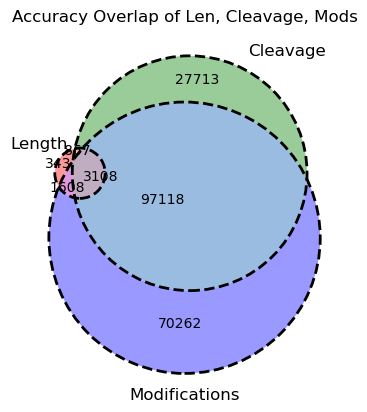

In [14]:
#import module
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt

# depict venn diagram
venn_arr = [5939, 24000, ]
v = venn3(subsets=[len_match, cleav_match, mod_match], set_labels = ('Length', 'Cleavage', 'Modifications'))

# # v.get_label_by_id("100").set_text("7k")
# v.get_label_by_id("100").set_text("")
# v.get_label_by_id("010").set_text("157k")
# # v.get_label_by_id("110").set_text("5k")
# v.get_label_by_id("110").set_text("")
# v.get_label_by_id("001").set_text("209k")
# # v.get_label_by_id("101").set_text("6k")
# v.get_label_by_id("101").set_text("")
# v.get_label_by_id("011").set_text("123k")
# # v.get_label_by_id("111").set_text("4k")
# v.get_label_by_id("111").set_text("")

# # add outline
venn3_circles(subsets=[len_match, cleav_match, mod_match], linestyle="dashed", linewidth=2)

# assign title
plt.title("Accuracy Overlap of Len, Cleavage, Mods")
plt.savefig('venns.png', dpi=300, bbox_inches='tight')
plt.show()


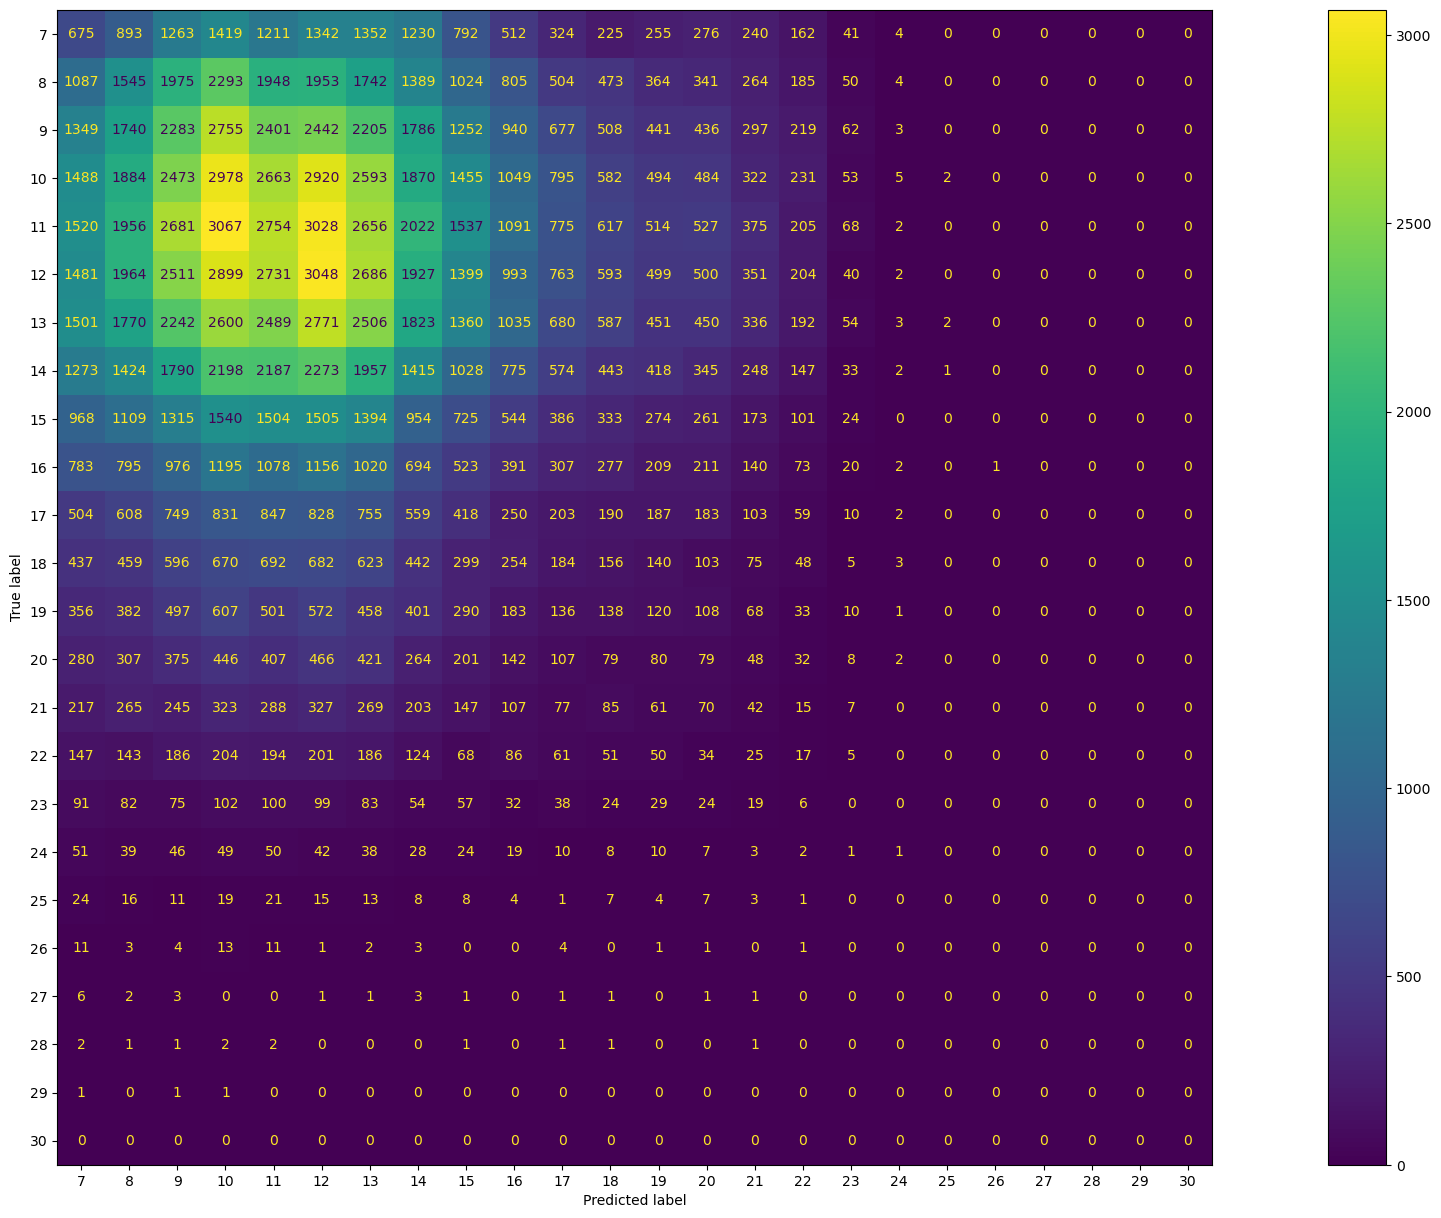

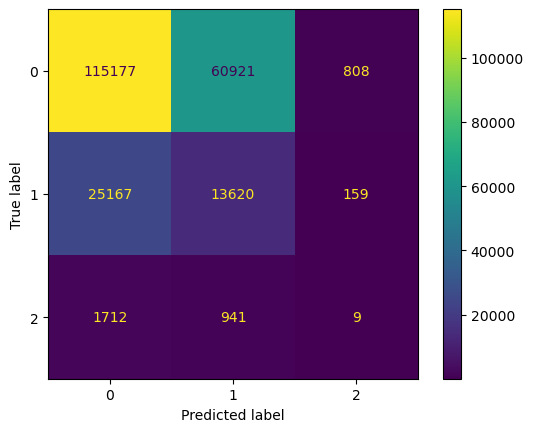

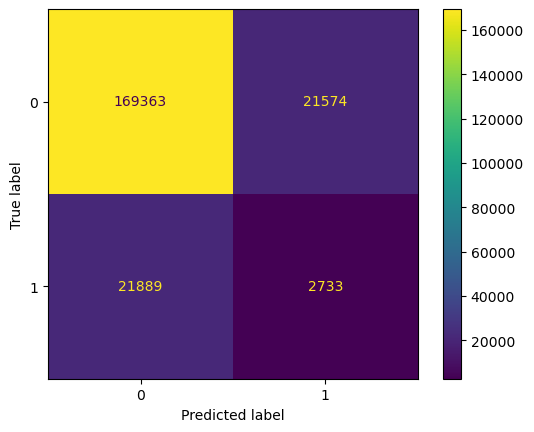

: 

In [35]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from matplotlib.pyplot import figure

lens_true = []
cleavs_true = []
mods_true = []
for pep_prop in pep_props:
    lens_true.append(pep_prop[1])
    cleavs_true.append(pep_prop[2])
    mods_true.append(pep_prop[3])

from sklearn.metrics import confusion_matrix

# len_cm = confusion_matrix(lens_true, lens)
# cleav_cm = confusion_matrix(cleavs_true, cleavs)
# mod_cm = confusion_matrix(mods_true, mods)

disp = ConfusionMatrixDisplay.from_predictions(lens_true, np.array(lens)+7, labels=np.arange(7, 31))
fig = disp.ax_.get_figure()
fig.set_figwidth(30)
fig.set_figheight(15)

disp = ConfusionMatrixDisplay.from_predictions(cleavs_true, cleavs)

disp = ConfusionMatrixDisplay.from_predictions(mods_true, mods, labels=[0, 1])
